### Загрузка библиотек 

In [1]:
import numpy as np

import pandas as pd
import pandas as pdload_predictor


import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
import pickle as pk

import xgboost as xgb

from mlframework import load_predictor

### Загрузка датасета 

In [4]:
df = pd.read_csv('../_/6. RD-5850 - Обучить модели на новой ОВ/data/stage_data.csv')

In [5]:
df.shape

(5674, 394)

In [6]:
df.head()

,project_id,equ_str_INN,nbk_num_Age,nbk_num_CHQ,equ_str_Snils,meg_num_Score,application_id,equ_num_RateCHQ,smev_str_status,equ_str_LastName,...,nbk-db_num_avg_income_nbk_12m_used_count_credits,equ_num_AvgWeightedAverageCatOverdueLineMicroloan,frontend_num_SimilarityMeasureMobileAndAdditional,kontur-frontend_bool_HasBankruptDataWithoutSnilsInn,juicy_num_TotalNumOfShortTermCreditApplicationsIn7days,equ_num_CountCreditsFor6monOverdueMoreThan30DaysMicroloan,equ-nbk_bit_HasActiveOverdueMoreThan30DaysFor6monMicroloan,prod_score,model,verdict
0,0,NaN,29.0,0.46258,1.327172e+10,0.077897,11021318,0.303972,VALID,ХАРИТОНОВА,...,13.0,0.088889,18.0,False,0.0,0,0.0,0.738249,122,0
1,0,NaN,40.0,0.44743,NaN,0.116104,11018484,0.189654,NaN,ЛЯДОВ,...,7.0,0.200000,18.0,False,0.0,0,0.0,0.038479,122,1
2,0,NaN,37.0,2.74684,NaN,0.122125,11019337,2.103541,NaN,МИРОМАНОВ,...,6.0,0.450000,14.0,False,0.0,0,1.0,0.006727,122,1
3,0,NaN,49.0,1.25892,NaN,0.105559,11024767,0.202314,NaN,ПОЛУБОТКО,...,3.0,0.069841,16.0,False,0.0,0,0.0,0.615067,122,0
4,0,NaN,33.0,0.00725,NaN,0.153607,11026102,0.065859,VALID,КРИУЛИНА,...,23.0,0.000000,18.0,False,0.0,0,0.0,0.825713,122,0


In [7]:
df[df['model'] == 128].shape[0]

7

In [8]:
df[df['model'] == 122].shape[0]

5667

### Predict 

In [9]:
model_path = '../_/6. RD-5850 - Обучить модели на новой ОВ/models/Эксперимент 4 на новой ОВ/runs/new short-term (48). test_2021_01 2021_12_21-09_59_12/predictors/new short-term (48). test_2021_01_all short-term.predictor'
model = load_predictor(model_path)

In [10]:
clean_model = model.model.model

with open('exp4_model.predictor', 'bw') as f:
    pk.dump(clean_model, f)

In [11]:
preproc_data = model.pipeline.transform(df)

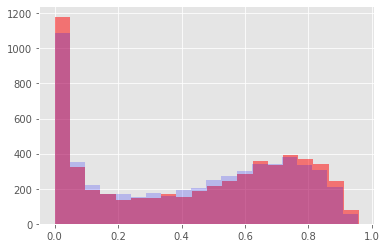

In [50]:
df['model_score'] = model.predict_proba(df)[:, 0]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(df['model_score'] , alpha = 0.5, lw=3, color='r', bins=20)
ax.hist(df['prod_score'], alpha = 0.2, lw=3, color='b', bins=20)

plt.show()

In [13]:
def get_new_tariffs(tariffs, prod_threshold):
    
    model_threshold = [] 

    model_threshold.append(prod_threshold[0])

    for i in range(len(prod_threshold) - 2): 
        prod_rate = df[(df['prod_score'] >= prod_threshold[i]) & (df['prod_score'] < prod_threshold[i+1])].shape[0] / df.shape[0]
        print('prod_rate:', prod_rate)

        delta = 100 
        threshold_ = 0

        for j in np.arange((prod_threshold[i+1]-0.03), (prod_threshold[i+1]+0.031), 0.005):

            model_rate = df[(df['model_score'] >= model_threshold[i]) & (df['model_score'] < j)].shape[0] / df.shape[0]

            if abs(prod_rate - model_rate) < delta:
                delta = abs(prod_rate - model_rate)
                threshold_ = j


        model_threshold.append(round(threshold_, 3))    


        print('model_rate:', df[(df['model_score'] >= model_threshold[i]) & (df['model_score'] < threshold_)].shape[0] / df.shape[0])
        print('')

    print('prod_rate:', df[(df['prod_score'] >= prod_threshold[-1]) & (df['prod_score'] <= 1)].shape[0] / df.shape[0])
    print('model_rate:', df[(df['model_score'] >= model_threshold[-1]) & (df['model_score'] <= 1)].shape[0] / df.shape[0])

    print('')

    model_threshold.append(prod_threshold[-1]) 

    print(model_threshold)
    print('')
    
    
    
    from tabulate import tabulate


    print(tabulate([[tariffs[i], 
                     model_threshold[i], 
                     model_threshold[i+1]] for i in range(len(tariffs))], 
                   headers=['tariff name', 'lower threshold', 'upper threshold']))


In [14]:
tariffs = ['Start1', 'Start2', 'Start', 'Silver1', 'Silver2', 'Silver3', 'Silver',
           'Gold1', 'Gold2', 'Gold3', 'Gold', 'Gold']

prod_threshold = [0, 0.5, 0.57, 0.63, 0.68, 0.72, 0.765, 0.81, 0.85, 0.89, 0.92, 0.93, 1] 

get_new_tariffs(tariffs, prod_threshold)

prod_rate: 0.5281988015509341
model_rate: 0.5274938315121608

prod_rate: 0.06785336623193514
model_rate: 0.06714839619316179

prod_rate: 0.06873457878040183
model_rate: 0.06820585125132182

prod_rate: 0.06150863588297498
model_rate: 0.06027493831512161

prod_rate: 0.05199154035953472
model_rate: 0.04846669016566796

prod_rate: 0.062037363412054986
model_rate: 0.06397603101868171

prod_rate: 0.05657384561156151
model_rate: 0.05498766302432147

prod_rate: 0.04582305252026789
model_rate: 0.04758547761720127

prod_rate: 0.03542474444836095
model_rate: 0.03718716954529432

prod_rate: 0.01691928093056045
model_rate: 0.015861825872400422

prod_rate: 0.003172365174480085
model_rate: 0.0040535777229467745

prod_rate: 0.0
model_rate: 0.004758547761720127

[0, 0.52, 0.595, 0.65, 0.7, 0.735, 0.78, 0.82, 0.86, 0.9, 0.92, 0.93, 1]

tariff name      lower threshold    upper threshold
-------------  -----------------  -----------------
Start1                     0                  0.52
Start2         

    TARIFF_SHORT_BY_SCORE_NEW: Tuple[TariffWithThresholds] = tuple(  # type: ignore
        TariffWithThresholds.parse_obj(obj_data)
        for obj_data in (
            {"tariff_name": "Start1", "lower_threshold": 0, "upper_threshold": 0.5},
            {"tariff_name": "Start2", "lower_threshold": 0.5, "upper_threshold": 0.57},
            {"tariff_name": "Start", "lower_threshold": 0.57, "upper_threshold": 0.63},
            {"tariff_name": "Silver1", "lower_threshold": 0.63, "upper_threshold": 0.68},
            {"tariff_name": "Silver2", "lower_threshold": 0.68, "upper_threshold": 0.72},
            {"tariff_name": "Silver3", "lower_threshold": 0.72, "upper_threshold": 0.765},
            {"tariff_name": "Silver", "lower_threshold": 0.765, "upper_threshold": 0.81},
            {"tariff_name": "Gold1", "lower_threshold": 0.81, "upper_threshold": 0.85},
            {"tariff_name": "Gold2", "lower_threshold": 0.85, "upper_threshold": 0.89},
            {"tariff_name": "Gold3", "lower_threshold": 0.89, "upper_threshold": 0.92},
            {"tariff_name": "Gold", "lower_threshold": 0.92, "upper_threshold": 0.93},
            {"tariff_name": "Gold", "lower_threshold": 0.93, "upper_threshold": 1},
        )
    )



Проверить, есть ли сильные изменения скора у заявок. 

In [15]:
df['delta_score'] = df['model_score'] - df['prod_score']

<AxesSubplot:>

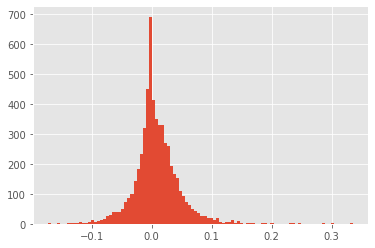

In [16]:
df['delta_score'].hist(bins=100)

In [30]:
np.round((df[abs(df['delta_score']) > 0.1].shape[0] / df.shape[0]), 5)

0.02256

In [17]:
df[abs(df['delta_score']) > 0.15][['prod_score', 'model_score', 'delta_score']][:60]

,prod_score,model_score,delta_score
156,0.368629,0.560576,0.191946
324,0.240425,0.086435,-0.153990
486,0.202033,0.365240,0.163207
845,0.282803,0.448273,0.165470
1047,0.200459,0.448235,0.247776
1362,0.516906,0.719151,0.202245
1433,0.338570,0.168185,-0.170384
1684,0.099834,0.270104,0.170270
2237,0.479096,0.665000,0.185904
3140,0.286514,0.621448,0.334934


Максимальная дельта изменения скора среди заявок.

In [18]:
print('max delta:', abs((df['delta_score'])).max())

max delta: 0.33493411540985113


Посчитать средний скор(в целом/для одобрения). 

In [25]:
print('средний скор на продовой модели (весь поток):', np.round(df['prod_score'].mean(), 5))
print('средний скор на новой модели (весь поток):   ', np.round(df['model_score'].mean(), 5))

средний скор на продовой модели (весь поток): 0.42467
средний скор на новой модели (весь поток):    0.43266


In [26]:
print('средний скор на продовой модели (одобренные):', np.round(df[df['verdict'] == 1]['prod_score'].mean(), 5))
print('средний скор на новой модели (одобренные):   ', np.round(df[df['verdict'] == 1]['model_score'].mean(), 5))

средний скор на продовой модели (одобренные): 0.05837
средний скор на новой модели (одобренные):    0.05154


Какой процент(количество) с одобрения получили блок. 

    Нижний порог по продовой модели 122:     0.2
    Верхний порог по продовой модели 122:    0.2

    Нижний порог по продовой модели 128:     0.25
    Верхний порог по продовой модели 128:    0.25

In [41]:
np.unique(df[df['prod_score'] >= 0.2]['verdict'])

array([0])

In [43]:
np.unique(df[df['prod_score'] < 0.2]['verdict'])

array([1])

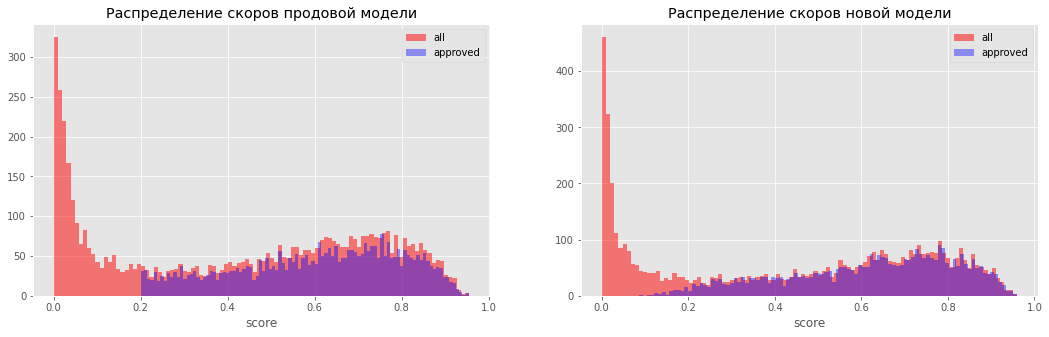

In [68]:
df['model_score'] = model.predict_proba(df)[:, 0]

fig = plt.figure(figsize=(18, 5)) 

ax1 = plt.subplot(1,2,1)

plt.hist(df['prod_score'], alpha = 0.5, lw=3, color='r', bins=100, label='all')
plt.hist(df[df['verdict'] == 0]['prod_score'], alpha = 0.4, lw=3, color='b', bins=100, label='approved')
plt.title('Распределение скоров продовой модели')
plt.xlabel('score')
plt.legend()


ax2 = plt.subplot(1,2,2)

plt.hist(df['model_score'], alpha = 0.5, lw=3, color='r', bins=100, label='all')
plt.hist(df[df['verdict'] == 0]['model_score'], alpha = 0.4, lw=3, color='b', bins=100, label='approved')
plt.title('Распределение скоров новой модели')
plt.xlabel('score')
plt.legend()


plt.show()

In [44]:
df[df['prod_score'] >= 0.2]['model_score'].min()

0.08643478

In [87]:
threshold = 0.2

prod_rate = df[df['prod_score'] >= threshold].shape[0] / df.shape[0] 

print('Старый порог:', threshold)
print(prod_rate)
print('')


delta = 100 
threshold_ = 0 

for j in np.arange((threshold-0.05), (threshold+0.05), 0.005):
    model_rate = df[df['model_score'] >= j].shape[0] / df.shape[0] 

    if abs(prod_rate - model_rate) < delta:
        delta = abs(prod_rate - model_rate)
        threshold_ = j

print('Новый порог:', round(threshold_, 4))
print(df[df['model_score'] >= threshold_].shape[0] / df.shape[0])

Старый порог: 0.2
0.6713077194219246

Новый порог: 0.19
0.6721889319703913
